In [1]:
# set conda
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local

# install psi4
!conda install -y psi4 python=3.7 -c psi4

# set path
import sys
sys.path.append("/usr/local/lib/python3.7/site-packages/")

# this command is needed to avoid "Loader" error.
!pip install distributed

--2022-04-27 12:37:38--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2022-04-27 12:37:38--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75660608 (72M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  72.16M  99.2MB/s    in 0.7s    

2022-04-27 12:37:39 (99.2 MB/s) - ‘Miniconda3-latest-Linu

In [2]:
# import Psi4
import psi4
# check Psi4 version
print(psi4.__version__)

1.5


In [3]:
import numpy as np

from psi4.driver.procrouting.response.scf_response import tdscf_excitations
from psi4.driver.p4util import spectrum

psi4.core.set_output_file("log.txt")

psi4.set_memory('10GB')
psi4.set_num_threads(2)

mol = psi4.geometry("""
0, 2
N  0.000000000000     0.000000000000    -0.079859033927
H  0.000000000000    -0.803611003426     0.554794694632
H  0.000000000000     0.803611003426     0.554794694632
""")

# input (PCM Solver)
pcm = '''
units = angstrom
medium
{
   SolverType = IEFPCM
   Solvent = Water
   Nonequilibrium = True
}
cavity
{
   radiiset= uff
   Type = GePol
   Area = 0.3
   Mode = Implicit
}
'''
psi4.set_options({'pcm': True, 
                  'save_jk': True,
                  'reference': 'uhf',
                  'scf_type': 'pk'})
psi4.pcm_helper(pcm)

e, wfn = psi4.energy("HF/def2-SVP", return_wfn=True, molecule=mol)
res = tdscf_excitations(wfn, states=5)

In [4]:
!cat log.txt


  Memory set to   9.313 GiB by Python driver.
  Threads set to 2 by Python driver.

Scratch directory: /tmp/

Scratch directory: /tmp/
  PCM does not make use of molecular symmetry: further calculations in C1 point group.

*** tstart() called on 7543b9aab969
*** at Wed Apr 27 12:40:58 2022

   => Loading Basis Set <=

    Name: DEF2-SVP
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry N          line   110 file /usr/local/share/psi4/basis/def2-svp.gbs 
    atoms 2-3 entry H          line    15 file /usr/local/share/psi4/basis/def2-svp.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              UHF Reference
                        2 Threads,   9536 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point

In [5]:
ld = open('log.txt')
lines = ld.readlines()
read_line = 0

e_calc = []
r_calc = []
for line in lines:
    if read_line > 0:
      read_line += 1
      if line.strip() == '':
        read_line = 0
      if read_line > 3:
        e_calc.append(f'TD-HF ROOT 0 -> ROOT {read_line-3} EXCITATION ENERGY: '+line.split()[5]+
                      ' [eV] - A SYMMETRY: GS->ES '+line.split()[1]+', (Trans) = '+line.split()[2]+' '+line.split()[3])
        r_calc.append(f'TD-HF ROOT 0 -> ROOT {read_line-3} OSCILLATOR STRENGTH (LEN): '+line.split()[7]+
                      ' [eV] - A SYMMETRY: GS->ES '+line.split()[1]+', (Trans) = '+line.split()[2]+' '+line.split()[3])
    if line.find("Excitation") >= 0 and line.find("Energy") >= 0:
      read_line = 1
e_calc
#r_calc

['TD-HF ROOT 0 -> ROOT 1 EXCITATION ENERGY: 2.44156 [eV] - A SYMMETRY: GS->ES A->A, (Trans) = (1 A)',
 'TD-HF ROOT 0 -> ROOT 2 EXCITATION ENERGY: 7.40140 [eV] - A SYMMETRY: GS->ES A->A, (Trans) = (1 A)',
 'TD-HF ROOT 0 -> ROOT 3 EXCITATION ENERGY: 9.12279 [eV] - A SYMMETRY: GS->ES A->A, (Trans) = (1 A)',
 'TD-HF ROOT 0 -> ROOT 4 EXCITATION ENERGY: 10.10602 [eV] - A SYMMETRY: GS->ES A->A, (Trans) = (1 A)',
 'TD-HF ROOT 0 -> ROOT 5 EXCITATION ENERGY: 10.23716 [eV] - A SYMMETRY: GS->ES A->A, (Trans) = (1 A)']

In [6]:
#! UHF PCM TDSCF 
# comparison against other implementations:
#CPCM solvation model excitation energies of NH2 radical [eV]:
#(Same radii, epsilon, refraction index, probe radius in each program)
#
#state	PSI4	ORCA	G09
#1	2.43618	2.457	2.4411
#2	7.39834	7.203	7.3993
#3	9.11054	8.991	9.1777
#4	10.1063	9.848	10.1017
#5	10.2178	10.365	10.3305

In [7]:
# get poles and residues to plot OPA and ECD spectra
poles = [r["EXCITATION ENERGY"] for r in res]
opa_residues = [np.linalg.norm(r["ELECTRIC DIPOLE TRANSITION MOMENT (LEN)"])**2 for r in res]
ecd_residues = [r["ROTATORY STRENGTH (LEN)"] for r in res]

opa_spectrum = spectrum(poles=poles, residues=opa_residues, gamma=0.01, out_units="nm")
ecd_spectrum = spectrum(poles=poles, residues=ecd_residues, kind="ECD", gamma=0.01, out_units="nm")

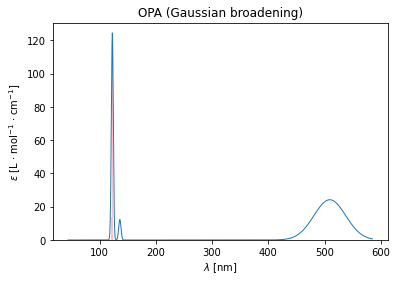

In [8]:
import matplotlib.pyplot as plt
plt.plot(opa_spectrum['convolution']['x'],opa_spectrum['convolution']['y'], linewidth=1.0)
plt.bar(opa_spectrum['sticks']['poles'],opa_spectrum['sticks']['residues'],color="pink", width=0.5)
plt.title('OPA (Gaussian broadening)')
plt.xlabel('$\lambda$ [nm]')
#plt.xlim(90, 170)
plt.ylabel('$\epsilon$ [L $\cdot$ mol$^{-1}$ $\cdot$ cm$^{-1}$]')
plt.savefig('opa_spectrum.pdf')

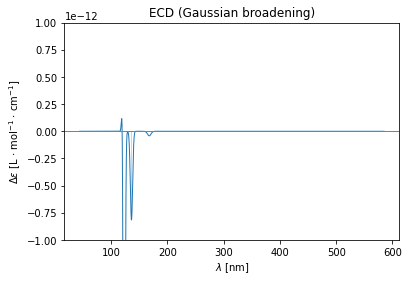

In [9]:
plt.plot(ecd_spectrum['convolution']['x'],ecd_spectrum['convolution']['y'], linewidth=1.0)
plt.bar(ecd_spectrum['sticks']['poles'],ecd_spectrum['sticks']['residues'],color="pink", width=0.5)
plt.title('ECD (Gaussian broadening)')
plt.xlabel('$\lambda$ [nm]')
#plt.xlim(90, 170)
plt.ylabel('$\Delta\epsilon$ [L $\cdot$ mol$^{-1}$ $\cdot$ cm$^{-1}$]')
plt.axhline(y=0.0,color="gray", linewidth=1, linestyle="-")
plt.savefig('ecd_spectrum.pdf')